vae2　オートエンコーダー

参考文献　我妻幸長　「はじめてのディープラーニング２」

In [1]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更してね。

In [3]:
%cd "ctorch210929/MiniCTorch_Prototype/jpynb"

/content/drive/My Drive/Colab Notebooks/ctorch210929/MiniCTorch_Prototype/jpynb


In [4]:
! pip install lark-parser

     |████████████████████████████████| 103 kB 9.4 MB/s 


In [5]:
import sys
sys.path.append("../minictorch")

import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import generator as GN
import converter as CV

サンプルデータ

In [6]:
import torch.utils as utils
from torchvision import datasets, transforms
from sklearn import datasets

img_size = 8
n_in = img_size * img_size
n_mid = 16
n_out = n_in
n_z = 2
n_batch = 32

digits_data = datasets.load_digits()
dd = np.asarray( digits_data.data, dtype=np.float32 )
dd /= 15
x_train = torch.from_numpy( dd ).clone()
t_train = digits_data.target
print(len(x_train))

1797


サンプルデータの図化

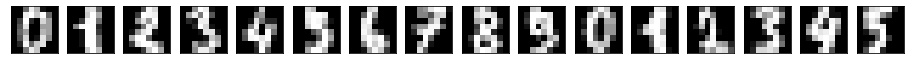

In [7]:
import matplotlib.pyplot as plt
n_img = 16

plt.figure( figsize=(16,3))
for i in range(n_img):
  ax = plt.subplot(3,n_img,i+1)
  plt.imshow(dd[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

ニューラルネットワークの定義

In [8]:
def mean_squared_error( x0, x1 ):
    diff = x0 - x1
    y = (diff**2).sum() / len(diff)
    return y;

def reconstruction( y, t ):
  eps = 1.0e-7
  e = t * torch.log(y+eps) + (1-t) * torch.log(1-y+eps) 
  z = e.sum() / len(y)
  return z;

def kl_divergence( mean, log_var ):
  g = 1 + log_var - mean**2 - torch.exp( log_var )
  y = 0.5 * g.sum() / len(mean)
  return y

import torch.distributions as td

class Net(torch.nn.Module):
  def __init__( self, n_in, n_mid, n_out, n_z, e ):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_in, n_mid)
    self.fc2_mean = nn.Linear(n_mid, n_z)
    self.fc2_var  = nn.Linear(n_mid, n_z)
    self.fc3 = nn.Linear(n_z  ,n_mid)
    self.fc4 = nn.Linear(n_mid,n_out)
    self.eps = e
    nn.init.constant_(self.fc1.bias,0)
    nn.init.constant_(self.fc2_mean.bias,0)
    nn.init.constant_(self.fc2_var.bias,0)
    nn.init.constant_(self.fc3.bias,0)
    nn.init.constant_(self.fc4.bias,0)

    #self.bce1 = nn.BCELoss()
  
  def forward( self, x ):
    # encoder
    x2 = F.relu( self.fc1(x) )
    self.mean    = self.fc2_mean(x2)
    self.log_var = self.fc2_var(x2)

    # reparametrization
    #eps = torch.randn( self.mean.shape )
    #nm = td.Normal( 0.0, 1.0 ) #torch.tensor([0.0]), torch.tensor([1.0]))
    #eps = nm.sample([ n_batch, n_z ])
    #eps = torch.normal( 0.0,1.0,[32,2] )
    #print("eps",eps)
    #self.z = self.mean + eps * torch.exp( 0.5 * self.log_var )
    #self.z = self.mean + self.eps * torch.exp( 0.5 * self.log_var )

    self.std = torch.exp( 0.5 * self.log_var )
    q_z = td.normal.Normal( self.mean, self.std )
    self.z = q_z.rsample()

    # decoder
    y = F.relu( self.fc3(self.z) )
    y = torch.sigmoid( self.fc4(y) )
    ##return y
    self.out = y
    
    #e1 = reconstruction( y, x )
    e1 = F.binary_cross_entropy( y , x, reduction="mean" )
    #e1 = self.bce1(y, x)
    #e1 = e1 *64

    #e2 = kl_divergence( self.mean, self.log_var )
    p_z = td.normal.Normal( torch.zeros_like(q_z.loc), torch.ones_like(q_z.scale) )
    e2  = td.kl_divergence( q_z, p_z ).sum()
    #print("e1,e2",e1,e2)

    self.loss1=e1
    self.loss2=e2

    #return -(e1+e2)
    return (e1+e2)

In [9]:
def test(x,e):
  model = Net( n_in, n_mid, n_out, n_z, e )

  trace = torch.jit.trace(model, x, strict=True)
  print(trace.graph)

x = x_train.clone().detach()
torch.reshape( x, (-1,n_in) )

x = x[0:n_batch,:]

e = torch.randn( n_batch, 2 )

test(x,e)

graph(%self.1 : __torch__.Net,
      %x : Float(32, 64, strides=[64, 1], requires_grad=0, device=cpu)):
  %161 : __torch__.torch.nn.modules.linear.___torch_mangle_3.Linear = prim::GetAttr[name="fc4"](%self.1)
  %158 : __torch__.torch.nn.modules.linear.___torch_mangle_2.Linear = prim::GetAttr[name="fc3"](%self.1)
  %155 : __torch__.torch.nn.modules.linear.___torch_mangle_1.Linear = prim::GetAttr[name="fc2_var"](%self.1)
  %152 : __torch__.torch.nn.modules.linear.___torch_mangle_0.Linear = prim::GetAttr[name="fc2_mean"](%self.1)
  %149 : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="fc1"](%self.1)
  %167 : Tensor = prim::CallMethod[name="forward"](%149, %x)
  %input.3 : Float(32, 16, strides=[16, 1], requires_grad=1, device=cpu) = aten::relu(%167) # /usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1298:0
  %168 : Tensor = prim::CallMethod[name="forward"](%152, %input.3)
  %169 : Tensor = prim::CallMethod[name="forward"](%155, %input.3)
  %33 : Double(require

/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:985: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%eps : Float(32, 2, strides=[2, 1], requires_grad=0, device=cpu) = aten::normal(%58, %66, %67) # /usr/local/lib/python3.7/dist-packages/torch/distributions/utils.py:47:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  _module_class,
/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:985: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
With rtol=1e-05 and atol=1e-05, found 1 element(s) (out of 1) whose difference(s) exceeded the margin of error (including 0 nan comparisons). The greatest difference was 0.0006568431854248047 (1.38968825340271 vs. 1.3903450965881348), which occurred at index 0.
  _module_class,


In [10]:
def generate_json( json_path, input, e ):

    model = Net( n_in, n_mid, n_out, n_z, e )

    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        GN.generate_minictorch_file( model, input, json_path )

    return model

In [11]:
torch.manual_seed( 1 )

project = 'vae2'
json_path = '../network/' + project +'.json'

x = x_train.clone().detach()
torch.reshape( x, (-1,n_in) )

x = x[0:n_batch,:]
#print(type(x))
print(x.shape)
#x.requires_grad = True

e = torch.randn( n_batch, 2 )
#print("eps",e)

model = generate_json( json_path, x, e )

#x.requires_grad = True

with torch.set_grad_enabled(True):
  model.eval()
  output = model( x )
  print("output",output)
  output.backward()
  #print("output",output.grad)
  print("loss1",model.loss1)
  print("loss2",model.loss2)
  print("input_grad",x.grad)

torch.Size([32, 64])
[SAVE] ../network/vae2.json
skip: Net/Linear[fc1]/weight/149
skip: Net/Linear[fc1]/weight/149
skip: Net/Linear[fc2_mean]/weight/152
skip: Net/Linear[fc2_mean]/weight/152
skip: Net/Linear[fc2_var]/weight/155
skip: Net/Linear[fc2_var]/weight/155
skip: Net/Linear[fc3]/weight/158
skip: Net/Linear[fc3]/weight/158
skip: Net/Linear[fc4]/weight/161
skip: Net/Linear[fc4]/weight/161


/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:985: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%eps : Float(32, 2, strides=[2, 1], requires_grad=0, device=cpu) = aten::normal(%58, %66, %67) # /usr/local/lib/python3.7/dist-packages/torch/distributions/utils.py:47:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  _module_class,
/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:985: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
With rtol=1e-05 and atol=1e-05, found 1 element(s) (out of 1) whose difference(s) exceeded the margin of error (including 0 nan comparisons). The greatest difference was 0.00352323055267334 (1.3834935426712036 vs. 1.3799703121185303), which occurred at index 0.
  _module_class,


output tensor(1.3793, grad_fn=<AddBackward0>)
loss1 tensor(0.6970, grad_fn=<BinaryCrossEntropyBackward>)
loss2 tensor(0.6824, grad_fn=<SumBackward0>)
input_grad None


In [ ]:
"""
def convert_json( project, folder, model, input_x, json_path, rand_flag=0 ):

    #folder = "src"
    cpp_fname   = project + ".cpp"
    param_fname = project + "_param.cpp"
    cpp_path    = folder + "/" + cpp_fname
    param_path  = folder + "/" + param_fname
    make_path   = folder + "/" + "Makefile"

    # load json file
    print( "[JSON]", json_path )
    fp = open( json_path )
    obj = json.load( fp )

    # save parameter file
    code1 = CV.c_param_generator( obj, model, input_x )
    if len( code1 ) > 0:
       print( "[PARAM]", param_path )
       ofparam = open( param_path, "w" )
       ofparam.write( code1 )

    # save cpp file
    print( "[CPP]  ", cpp_path )
    code2 = CV.c_code_generator( obj, model, rand_flag )

    #ofp=open(args.path+"/"+args.output,"w")
    ofp = open( cpp_path, "w" )
    ofp.write( code2 )

    # save make file
    print( "[MAKE] ", make_path )
    make_code = CV.makefile_generator( cpp_fname )

    #makefp=open(args.path+"/"+"Makefile","w")
    makefp = open( make_path, "w" )
    makefp.write( make_code )

convert_json( project, "src", model, x, json_path )
"""

In [12]:
CV.convert_json( project, "../src", model, x, json_path )

[JSON] ../network/vae2.json
{'name': 'Net/Linear[fc1]/weight/173', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
{'name': 'Net/Linear[fc1]/bias/172', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}
{'name': 'Net/Linear[fc2_mean]/weight/176', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 5}
{'name': 'Net/Linear[fc2_mean]/bias/175', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 6}
{'name': 'Net/Linear[fc2_var]/weight/179', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [10], 'sorted_id': 8}
{'name': 'Net/Linear[fc2_var]/bias/178', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [10], 'sorted_id': 9}
{'name': 'Net/Linear[fc3]/weight/182', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [47], 'sorted_id': 45}
{'name': 'Net/Linear[fc3]/bias/181', 'op': 'prim::Get

In [15]:
!g++ -std=c++14 ../src/vae2.cpp ../src/vae2_param.cpp  -I ../../../ctorch/lib -lcblas -o ../bin/vae2

(注意) ctorch/libにxtensor関連のincludeを置いています。

In [16]:
!../bin/vae2

### forward computation ...
{ 1.377269}
### backward computation ...
input_grad{{-0.00321 , -0.002135,  0.004704, ..., -0.000628, -0.004311, -0.005155},
 {-0.011554, -0.000128,  0.00318 , ..., -0.000509, -0.010749, -0.008572},
 {-0.007079,  0.004047,  0.002193, ...,  0.001067, -0.004554, -0.004626},
 ..., 
 {-0.00756 ,  0.002112,  0.002471, ...,  0.000837, -0.003364, -0.00645 },
 {-0.003647, -0.002078,  0.005188, ..., -0.000259, -0.004205, -0.005217},
 {-0.001296,  0.000206,  0.001456, ...,  0.002875, -0.000528, -0.006141}}


勾配計算

In [18]:
torch.manual_seed( 1 )

project = 'vae2'

x = x_train.clone().detach()
torch.reshape( x, (-1,n_in) )

#n_batch = 32 # 1792

x = x[0:n_batch,:]
#print(type(x))
#print(x.shape)
#x.requires_grad = True

e = torch.randn( n_batch, 2 )
#print("eps",e)

net = Net( n_in, n_mid, n_out, n_z, e )
net.train()

lr=0.001
opt = torch.optim.SGD(net.parameters(), lr)
#mse = torch.nn.MSELoss()

epoch_loss = []
epoch_num = 200; 
for epoch in range(epoch_num):

  loss = net( x )

  print("loss",loss)

  opt.zero_grad()
  loss.backward()
  #print("fc1_w",model.fc1.weight.grad)
  #print("fc1_b",model.fc1.bias.grad)
  #print("fc1_rx",model.fc1)
  #print("fc1_z",model.rz.grad)
  """
  print("fc2_mean_w",model.fc2_mean.weight.grad)
  print("fc2_mean_b",model.fc2_mean.bias.grad)
  print("fc2_var_w",model.fc2_var.weight.grad)
  print("fc2_var_b",model.fc2_var.bias.grad)
  """
  #print("output",output.grad)

  opt.step()
  print("EPOCH: {} loss: {}".format(epoch, loss))
  epoch_loss.append( loss )
 

loss tensor(1.3787, grad_fn=<AddBackward0>)
EPOCH: 0 loss: 1.3786983489990234
loss tensor(1.2888, grad_fn=<AddBackward0>)
EPOCH: 1 loss: 1.2888193130493164
loss tensor(1.2150, grad_fn=<AddBackward0>)
EPOCH: 2 loss: 1.2149816751480103
loss tensor(1.1518, grad_fn=<AddBackward0>)
EPOCH: 3 loss: 1.1518285274505615
loss tensor(1.1027, grad_fn=<AddBackward0>)
EPOCH: 4 loss: 1.1026856899261475
loss tensor(1.0644, grad_fn=<AddBackward0>)
EPOCH: 5 loss: 1.0643843412399292
loss tensor(1.0292, grad_fn=<AddBackward0>)
EPOCH: 6 loss: 1.0291879177093506
loss tensor(1.0013, grad_fn=<AddBackward0>)
EPOCH: 7 loss: 1.001307725906372
loss tensor(0.9833, grad_fn=<AddBackward0>)
EPOCH: 8 loss: 0.983328104019165
loss tensor(0.9605, grad_fn=<AddBackward0>)
EPOCH: 9 loss: 0.9605247378349304
loss tensor(0.9389, grad_fn=<AddBackward0>)
EPOCH: 10 loss: 0.938908576965332
loss tensor(0.9269, grad_fn=<AddBackward0>)
EPOCH: 11 loss: 0.9268635511398315
loss tensor(0.9124, grad_fn=<AddBackward0>)
EPOCH: 12 loss: 0.912

ミニバッチのよる最適化

In [19]:
torch.manual_seed( 1 )

epochs = 200
batch_size = 32
#interval = 5  # 経過の表示間隔

e = torch.randn( batch_size, 2 )
#print("eps",e)

net = Net( n_in, n_mid, n_out, n_z, e )
net.train()

lr = 0.001
type=1
if type==1:
  opt = torch.optim.SGD(net.parameters(), lr)
  #opt = torch.optim.Adagrad(net.parameters(), lr)
if type==2:
  opt = torch.optim.Adam(net.parameters(), lr )

epoch_loss = []
epoch_loss2 = []

#rec_error_record = []
#reg_error_record = []
#total_error_record = []
n_batch = len(x_train) // batch_size  # 1エポックあたりのバッチ数
print("batch",n_batch,len(x_train),batch_size)

for i in range(epochs):
        
    # -- 学習 -- 
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)  # インデックスをシャッフルする

    total_loss = 0.0
    for j in range(n_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[ j*batch_size : (j+1)*batch_size ]
        x_mb = x_train[mb_index, :]
        #x_mb.requires_grad = True
        #print("x?mb",x_mb.shape)
        
        # 順伝播と逆伝播
        loss = net( x_mb )
        #print("loss",loss)
        #print("z",j,net.z)
        total_loss += loss;

        opt.zero_grad()
        loss.backward()
        #forward_propagation(x_mb)
        #backpropagation(x_mb)
        
        # 重みとバイアスの更新
        opt.step()
        #print("EPOCH: {} {} loss: {}".format(i,j, loss))
        #epoch_loss.append( loss )
        #update_params()

    # -- 誤差を求める --
    print("EPOCH: {} loss: {}".format(i, total_loss))
    #epoch_loss.append( total_loss )

    x2 = x_train.clone().detach()
    torch.reshape( x2, (-1,n_in) )
    #print(x2.shape)

    net.eval()

    #net.eps = torch.randn( len(x_train), 2 )

    loss = net( x2 )
    print("loss",loss,net.loss1,net.loss2)
    #print("out shape", net.out.shape,net.out)
    if type==1:
      epoch_loss.append( loss )
    if type==2:
      epoch_loss2.append( loss )

    """
    forward_propagation(x_train)

    rec_error = get_rec_error(output_layer.y, x_train)
    reg_error = get_reg_error(mu_layer.y, log_var_layer.y)
    total_error = rec_error + reg_error

    rec_error_record.append(rec_error)
    reg_error_record.append(reg_error)
    total_error_record.append(total_error)

    # -- 経過の表示 -- 
    if i%interval == 0:
        print("Epoch:", i, "Rec_error:", rec_error, "Reg_error", reg_error, "Total_error", total_error)
    """

batch 56 1797 32
EPOCH: 0 loss: 49.696964263916016
loss tensor(6.9752, grad_fn=<AddBackward0>) tensor(0.7007, grad_fn=<BinaryCrossEntropyBackward>) tensor(6.2745, grad_fn=<SumBackward0>)
EPOCH: 1 loss: 44.66013717651367
loss tensor(5.3926, grad_fn=<AddBackward0>) tensor(0.7004, grad_fn=<BinaryCrossEntropyBackward>) tensor(4.6923, grad_fn=<SumBackward0>)
EPOCH: 2 loss: 43.396949768066406
loss tensor(4.4438, grad_fn=<AddBackward0>) tensor(0.7005, grad_fn=<BinaryCrossEntropyBackward>) tensor(3.7432, grad_fn=<SumBackward0>)
EPOCH: 3 loss: 42.61688232421875
loss tensor(3.7976, grad_fn=<AddBackward0>) tensor(0.7000, grad_fn=<BinaryCrossEntropyBackward>) tensor(3.0976, grad_fn=<SumBackward0>)
EPOCH: 4 loss: 42.05685043334961
loss tensor(3.3300, grad_fn=<AddBackward0>) tensor(0.7000, grad_fn=<BinaryCrossEntropyBackward>) tensor(2.6300, grad_fn=<SumBackward0>)
EPOCH: 5 loss: 41.63395690917969
loss tensor(2.9717, grad_fn=<AddBackward0>) tensor(0.7000, grad_fn=<BinaryCrossEntropyBackward>) tensor

学習の収束の図化 (python)

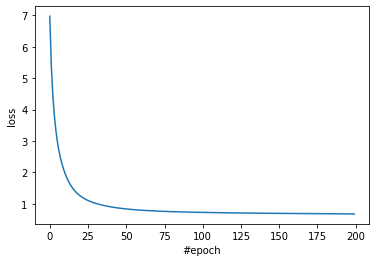

In [29]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

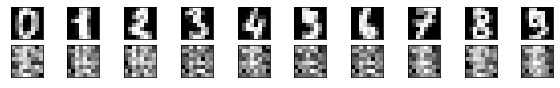

In [21]:
n_img2=10
x2=x[:n_img2]

o = net.out.to('cpu').detach().numpy().copy()

plt.figure( figsize=(10,2))
for i in range(n_img2):
  #input image
  ax = plt.subplot(3,n_img2,i+1)
  plt.imshow( x2[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  #output image
  ax = plt.subplot(3,n_img2,i+1+n_img2)
  plt.imshow( o[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

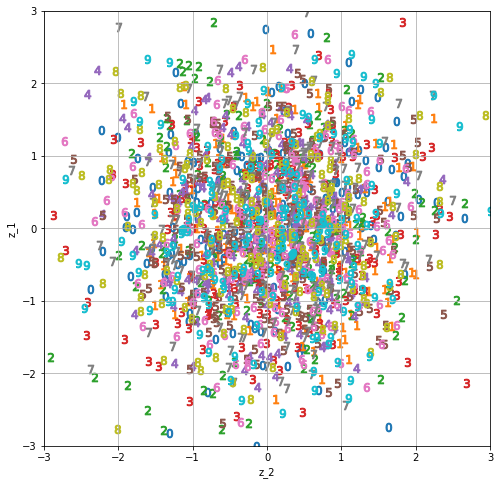

In [22]:
t2 = t_train #[:n_batch]

plt.figure(figsize=(8,8))
for i in range(10):
  zt = net.z[t2==i]
  z_1 = zt[:,0]
  z_2 = zt[:,1]
  marker= "$"+str(i)+"$"
  plt.scatter(z_2.tolist(), z_1.tolist(), marker=marker,s=75)

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()

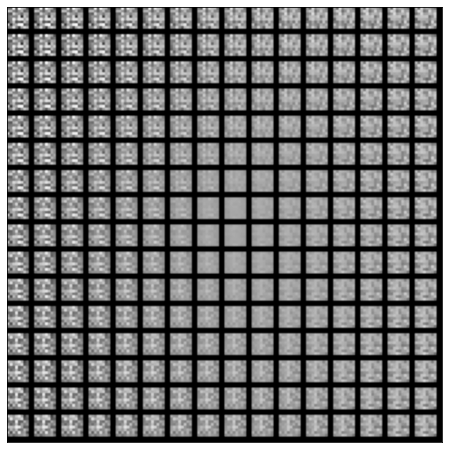

In [23]:
n_img3=16
img_size_spaced = img_size + 2
matrix_image = np.zeros(( img_size_spaced*n_img3, img_size_spaced*n_img3 ))

z_1 = np.linspace( 3, -3, n_img3 )
z_2 = np.linspace( 3, -3, n_img3 )

with torch.set_grad_enabled(False):
  for i, z1 in enumerate(z_1):
    for j,z2 in enumerate(z_2):

      z = np.array([z1, z2])
      zz = torch.from_numpy( z ).float()
      
      y = F.relu( net.fc3(zz) )
      o = torch.sigmoid( net.fc4(y) )
      image = o.reshape(img_size, img_size)
      top  = i * img_size_spaced
      left = j * img_size_spaced
      matrix_image[top:top+img_size, left:left+img_size] = image

plt.figure(figsize=(8,8))
plt.imshow( matrix_image.tolist(), cmap="Greys_r" )
plt.tick_params( labelbottom=False, labelleft=False, bottom=False, left=False )
plt.show()

最適化実行

全入力データを vae1_data.cpp に出力する

In [25]:
def output_datafile( folder, project, in_data ):
    data_fname = project + "_data.cpp"
    data_path  = folder + "/" + data_fname

    # save data file
    code = CV.c_data_generator( in_data )
    if len( code ) > 0:
       print( "[DATA]", data_path )
       ofparam = open( data_path, "w" )
       ofparam.write( code )

output_datafile( "../src", project, dd )

param: indata  - str loop  5000  /  14375
param: indata  - str loop  10000  /  14375
[DATA] ../src/vae1_data.cpp


In [26]:
!g++ -std=c++14 ../src/vae2_opt.cpp ../src/vae2_param.cpp  ../src/vae1_data.cpp   -I ../../../ctorch/lib -lcblas -o ../bin/vae2_opt

In [28]:
!../bin/vae2_opt

indata 1797,64
batch  56,32
epoch_num : 200
total_loss 0 loss-42.9931
epoch 0 - loss { 2.03243 } (  0.699403 , { 1.333027} ) 
total_loss 1 loss-39.9503
epoch 1 - loss { 1.241983} (  0.69745  , { 0.544533} ) 
total_loss 2 loss-39.3924
epoch 2 - loss { 1.005754} (  0.695129 , { 0.310625} ) 
total_loss 3 loss-39.102
epoch 3 - loss { 0.890006} (  0.693781 , { 0.196225} ) 
total_loss 4 loss-38.9617
epoch 4 - loss { 0.824428} (  0.691774 , { 0.132654} ) 
total_loss 5 loss-38.7827
epoch 5 - loss { 0.787032} (  0.689885 , { 0.097147} ) 
total_loss 6 loss-38.6474
epoch 6 - loss { 0.762749} (  0.687791 , { 0.074958} ) 
total_loss 7 loss-38.5406
epoch 7 - loss { 0.746094} (  0.686235 , { 0.059859} ) 
total_loss 8 loss-38.4299
epoch 8 - loss { 0.732967} (  0.684519 , { 0.048448} ) 
total_loss 9 loss-38.3523
epoch 9 - loss { 0.723055} (  0.683008 , { 0.040047} ) 
total_loss 10 loss-38.234
epoch 10 - loss { 0.714784} (  0.681151 , { 0.033632} ) 
total_loss 11 loss-38.1429
epoch 11 - loss { 0.708046}

c++ からの出力ファイルの読み込み

In [32]:
#load out file
f = open('./vae1.out', 'r')

epoch_loss = []
datalist = f.readlines()
for data in datalist:
  #print(data)
  epoch_loss.append( float(data) )

f.close()

print("epoch =", len(epoch_loss))
print( epoch_loss)

# load pred file
f2 = open('vae1.pred', 'r')

datalist = f2.readlines()

n1 = 10
n2 = 64
k = 0
for data in datalist:
  ds = data.split(',')
  if k==0:
    n1 = int(ds[0])
    n2 = int(ds[1])
    global v_pred
    v_pred = np.zeros( (n1,n2))
  else:
    for i in range(n2):
      v_pred[k-1,i] = float(ds[i])
  k = k+1

f2.close()

print("pred =", n1,n2 )
#print( y_pred )

# load z file
f3 = open('vae1.z', 'r')

datalist = f3.readlines()
n1 = 100
n2 = 2
k = 0
for data in datalist:
  ds = data.split(',')
  if k==0:
    nz1 = int(ds[0])
    nz2 = int(ds[1])
    z_pred = np.zeros( (nz1,nz2))
  else:
    z_pred[k-1,0] = float(ds[0])
    z_pred[k-1,1] = float(ds[1])
  k = k+1

f3.close()

print("z =", nz1,nz2 )
#print(z_pred)

epoch = 200
[33.315163, 29.588337, 28.864582, 28.606874, 28.399221, 28.196524, 28.112505, 27.971659, 27.893692, 27.743196, 27.667103, 27.463993, 27.312462, 27.131021, 26.99172, 26.916931, 26.820824, 26.766123, 26.719816, 26.643881, 26.562258, 26.530367, 26.381763, 26.348427, 26.247, 26.206259, 26.074146, 26.01207, 25.915354, 25.825445, 25.789684, 25.732431, 25.681158, 25.596584, 25.599388, 25.504528, 25.552197, 25.476049, 25.487141, 25.430086, 25.386909, 25.368185, 25.42617, 25.372347, 25.319706, 25.36867, 25.2885, 25.297209, 25.240147, 25.268906, 25.26305, 25.249092, 25.24477, 25.199209, 25.200945, 25.177311, 25.178785, 25.208733, 25.133114, 25.14896, 25.134329, 25.100973, 25.088497, 25.069168, 25.01796, 25.07704, 24.987013, 24.995789, 24.962414, 24.969923, 24.969856, 24.9928, 25.016535, 24.978628, 24.912752, 24.906364, 24.89068, 25.001881, 24.921247, 24.864115, 24.793262, 24.843006, 24.793827, 24.725113, 24.733711, 24.677113, 24.653231, 24.744532, 24.675917, 24.748131, 24.660444, 24.

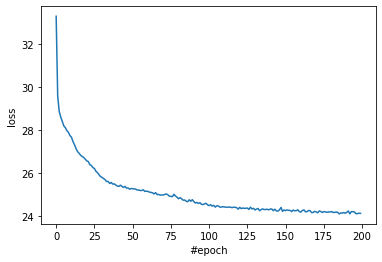

In [33]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

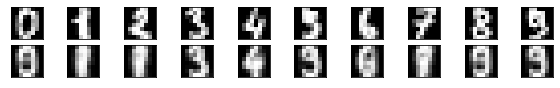

In [34]:
n_img5 = 10
x2 = x[:n_img5]

plt.figure( figsize=(10,2))
for i in range(n_img5):
  # input image
  ax = plt.subplot(3,n_img5,i+1)
  plt.imshow( x2[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # output image
  ax = plt.subplot(3,n_img5,i+1+n_img5)
  plt.imshow( v_pred[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

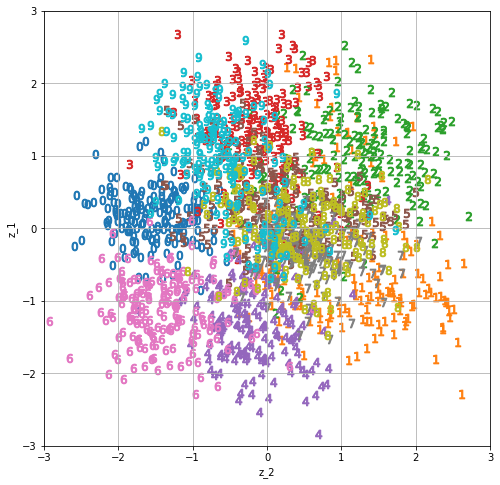

In [35]:
t2 = t_train #[:n_batch]

plt.figure(figsize=(8,8))
for i in range(10):
  zt = z_pred[t2==i]
  z_1 = zt[:,0]
  z_2 = zt[:,1]
  marker= "$"+str(i)+"$"
  plt.scatter( z_2.tolist(),  z_1.tolist(), marker=marker,s=75 )

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()

In [ ]:
import torch.distributions as tdist

n = tdist.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

e = n.sample((n_mid,))

In [ ]:
e

tensor([[ 0.5516],
        [-1.4746],
        [-1.2032],
        [-0.4709],
        [ 1.0430],
        [-0.9447],
        [ 0.7663],
        [-0.8108],
        [-0.7571],
        [ 0.6683],
        [-0.9177],
        [-0.1356],
        [-0.8786],
        [ 3.5638],
        [-1.4244],
        [-0.5050]])

In [ ]:
e2= torch.randn(n_mid)
print(e2)

tensor([ 1.4625,  0.0852,  0.2403, -0.7425, -1.1566, -1.9472, -0.0739,  1.4408,
        -1.5811,  0.1749,  1.1583,  0.6945, -0.4813, -0.2892,  1.3323, -0.9172])
